In [2]:
import mmf_setup;mmf_setup.nbinit(hgroot=False)
from mmfutils.contexts import NoInterrupt
import hfb_dir_init
from mmfutils.plot import imcontourf
from importlib import reload  # Python 3.4+

<IPython.core.display.Javascript object>

# Understanding 2D BdG Numerical Simulation
I find it's not easy to make a smooth translation from abstract knowledge of quantum theory to 2D numerical code, it's good to decompose all details first, and make connection to every line of code.

start with schodinger equation for 2D system, it should look like:
$$
H(x,y,t)\psi(x,y)=E\psi(x,y)
$$

the wavefunction in a 2D grid can be presented as a 2D matrix
$$\psi =
\begin{pmatrix}
    \psi_{1,1} & \psi_{1,2}&...&\psi_{1,N}\\
    \psi_{2,1} & \psi_{2,1}&...&\psi_{1,N}\\
    \vdots\\
    e^\psi_{N,1} & \psi_{N,2}&...&\psi_{N,N}\\
\end{pmatrix}
$$

Then, for any operator, it's matrix element form can be defined as:

\begin{align}
O_{m,n}&=\braket{\psi_m |\hat{O}|\psi_n}\\
&= \int dx dy {}\psi_{m}^*(x,y)\hat{O}\psi_n(x,y) \\
&=\Delta_x\Delta_y\sum_{x,y} ???
\end{align}

Depends on what the operator, if $\hat{O}$ is potential operator depends only on spatial coordinate $x,y$, we can easily have: 
\begin{align}
O_{m,n}&=\braket{\psi_m |\hat{O}|\psi_n}\\
&= \int dx dy {}\psi_m(x,y)\hat{O}(x,y)\psi_n(x,y) \\
&=\Delta_x\Delta_y\sum_{x,y} \psi_m^*(x,y)\hat{O}(x,y)\psi_n(x,y) \\
&=\Delta_x\Delta_y (\psi_{1,1}^* O_{1,1}\psi_{1,1}+ \psi_{1,2}^* O_{1,2}\psi_{1,2} +...+\psi_{2,1}^* O_{2,1}\psi_{2,1}+ \psi_{2,1}^* O_{2,1}\psi_{2,1} +...+...) \\
&=\Delta_x\Delta_y (\abs{\psi_{1,1}}^2 O_{1,1}+ \abs{\psi_{1,2}}^2 O_{1,2} +...+\abs{\psi_{2,1}}^2 O_{2,1}+ \abs{\psi_{2,1}}^2 O_{2,1} +...+...) \\
&=O(x,y)
\end{align}
where $\Delta_x, \Delta_y$ are the lattice spacings, and operators that depends only on spacial freedoms are trial, as we can see we just need to descetize them in lattice. **What's a fool I am to go through such long way to find it, LOL!**

### Fourier integral to Fourier series

Similar as the 1D FFT
$$
  FFT[\psi(x)] = \int\d{x}\; e^{-\I k x}\psi(x) = \frac{L}{N}\sum_{n} e^{-\I k x_n}\psi(x_n),\\
  FFT^{-1}(\psi_k) = \int\frac{\d{k}}{(2\pi)}\; e^{\I k x}\psi_k = \frac{1}{L}\sum_{m} e^{\I k_m x}\psi_{k_m}.
$$
we can extend these relations to 2D case without difficulty:
$$
  FFT[\psi(x,y)] = \int dx dy e^{-i(k_x x +k_y y)}\psi(x) = \frac{L_x L_y}{N_x N_y}\sum_{m,n} e^{-i (k_m x_m + k_n y_n)}\psi(x_n,y_n)\tag{1},\\
$$
$$
  FFT^{-1}[\psi(k_x,k_y)] = \int\frac{dk_x dk_y}{(4\pi^2)}\; e^{i (k_x x + k_y y)}\psi(k_x, k_y) = \frac{1}{L_x L_y}\sum_{m,n} e^{i (k_m x_m + k_n y_n)}\psi(k_m,k_n) \tag{2}
$$

For operators like kinetic operator, we may need to use Fourier transform to change the basis and backward. The kinetic term for 2D system is:

$$
\hat{T}=\frac{-\hbar^2}{2m}\left[\frac{\partial^2 }{\partial x^2}+\frac{\partial^2 }{\partial y^2}\right]\tag{3}
$$
when it acts on an wavefunction $\psi(x,y)$, yields another function $\phi(x,y)$
$$
\phi(x,y)=\hat{T}\psi(x,y)=\frac{-\hbar^2}{2m}\left[\frac{\partial^2 }{\partial x^2}+\frac{\partial^2 }{\partial y^2}\right]\psi(x,y)\tag{4}
$$
To make is more obviouse for computationn purpose, we use Fourier transform:

$$
\psi(x,y)=\frac{1}{2\pi}\int dk_x dk_y\psi(k_x,k_y)e^{-i(k_xx+k_yy)}\tag{5}
$$
where $\psi(k_x,k_y)$ is just Fourier transfrom of $\psi$, in mometum space.
$$
\psi(k_x,k_y)=\frac{1}{2\pi} \int dx dy \psi(x,y)e^{i(k_xx+k_yy)}\tag{6}
$$

If $\psi(x,y)$ is represented as (1), we can elimilate the second order partial differitial to get:

\begin{align}
\phi(x,y)&=\hat{T}\psi(x,y)\\
&=\frac{-\hbar^2}{2m}\left[\frac{\partial^2 }{\partial x^2}+\frac{\partial^2 }{\partial y^2}\right]\psi(x,y)\\
&=\frac{\hbar^2}{2m}\frac{1}{2\pi} \int dk_x dk_y \left[k_x^2 +k_y^2 \right]\psi(k_x,k_y)e^{-i(k_xx+k_yy)}\\
&=\frac{\hbar^2}{2m}\frac{1}{4\pi^2} \int dk_x dk_y dx' dy' \left[k_x^2 +k_y^2 \right]\psi(x',y')e^{-i(k_xx+k_yy-k_xx'- k_yy')}\tag{7}
\end{align}

Transfrom from integral to summation yiels:
$$
\phi(x,y) = \frac{\hbar^2}{2m}\frac{1}{4\pi^2} \frac{1}{N_xN_y} \sum_{k,l,m,n}\left[k_{x_k}^2+k_{y_l}^2\right]\psi(x'_m,y'_n)e^{-i\left[k_{x_k}(x-x'_m)+k_{y_l}(y-y'_n)\right]}\\
=\sum_{k_x,k_y,m,n}f(k_x,k_y)\psi(x'_m,y'_n)e^{-i\left[k_x(x-x'_m)+k_y(y-y'_n)\right]}\tag{8}
$$
where

$$
f(k_x,k_y)=\frac{\hbar^2}{2m}\frac{1}{4\pi^2} \frac{1}{N_xN_y} (k_x^2+k_y^2)
$$



Now, to present on matrix or tensor form, we need to represent the LHS as a matrix:

\begin{align}
\phi(x,y)
&=\sum_{k_x,k_y}f(k_x,k_y)e^{-i(k_xx+k_yy)}\left\{
\left[\psi(x'_1,y'_1)e^{i(k_xx'_1+k_yy'_1)} + \psi(x'_1,y'_2)e^{i(k_xx'_1+k_yy'_2)} +...+\psi(x'_1,y'_{N_y})e^{i(k_xx'_1+k_yy'_{N_y})}\right] +\\
\left[\psi(x'_2,y'_1)e^{i(k_xx'_2+k_yy'_1)} + \psi(x'_2,y'_2)e^{i(k_xx'_2+k_yy'_2)} +...+\psi(x'_2,y'_{N_y})e^{i(k_xx'_2+k_yy'_{N_y})}\right] +\\
\vdots \\
\left[\psi(x'_{N_x},y'_1)e^{i(k_xx'_{N_x}+k_yy'_1)} + \psi(x'_{N_x},y'_{N_x})e^{i(k_xx'_{N_x}+k_yy'_2)} +...+\psi(x'_{N_x},y'_{N_y})e^{i(k_xx'_{N_x}+k_yy'_{N_y})}\right]
\right\} \tag{9}
\end{align}

The braket terms can be rearragned as:
$$
e^{ik_xx'_1}\left[\psi(x'_1,y'_1)e^{ik_yy'_1} + \psi(x'_1,y'_2)e^{ik_yy'_2}+...\psi(x'_1,y'_{N_y})e^{ik_yy'_{N_y}}\right] +\\
e^{ik_xx'_2}\left[\psi(x'_2,y'_1)e^{ik_yy'_1} + \psi(x'_2,y'_2)e^{ik_yy'_2}+...\psi(x'_2,y'_{N_y})e^{ik_yy'_{N_y}}\right] +\\
\vdots\\
e^{ik_xx'_{x_N}}\left[\psi(x'_{x_N},y'_1)e^{ik_yy'_1} + \psi(x'_{x_N},y'_2)e^{ik_yy'_2}+...\psi(x'_{x_N},y'_{N_y})e^{ik_yy'_{N_y}}\right] \tag{10}
$$

Careful obervation it can be found we can put this into matrix form, and define it as:
$$
  M(k_x,k_y)=\begin{pmatrix}
    e^{ik_xx'_1} & e^{ik_xx'_2} & ... e^{ik_xx'_{N_x}}
  \end{pmatrix} 
  \begin{pmatrix}
    \psi(x'_1,y'_1) & \psi(x'_1,y'_2)&...&\psi(x'_1,y'_{N_y})\\
    \psi(x'_2,y'_1) & \psi(x'_2,y'_2)&...&\psi(x'_2,y'_{N_y})\\
    \vdots\\
    \psi(x'_{N_x},y'_1) & \psi(x'_{N_x},y'_2)&...&\psi(x'_{N_x},y'_{N_y})\\
  \end{pmatrix}
 \begin{pmatrix}
    e^{ik_yy'_1}\\
    e^{ik_yy'_2}\\
    \vdots\\
    e^{ik_yy'_{N_y}}\\
  \end{pmatrix}.\tag{11}
$$

Then $\phi(x,y)$ can be put as:
\begin{align}
\phi(x,y) 
&= \sum_{k_x,k_y} f(k_x,k_y)M(k_x,k_y)e^{-i(k_xx+k_yy)} \\
&=
\begin{pmatrix}
    e^{-ik_{x_1}x} & e^{-ik_{x_2}x} & ... e^{-ik_{x_{N_x}}x}
  \end{pmatrix} 
  \begin{pmatrix}
     Mf(k_{x_1},k_{y_1}) & Mf(k_{x_1},k_{y_2}&...&Mf(k_{x_1},k_{y_{N_y}})\\
    Mf(k_{x_2},k_{y_1}) & Mf(k_{x_2},k_{y_2}&...&Mf(k_{x_2},k_{y_{N_y}})\\
    \vdots\\
    Mf(k_{x_{N_x}},k_{y_1}) & Mf(k_{x_{N_x}},k_{y_2}&...&Mf(k_{x_{N_x}},k_{y_{N_y}})\\
  \end{pmatrix}
 \begin{pmatrix}
    e^{-ik_{y_1}y}\\
    e^{-ik_{y_2}y}\\
    \vdots\\
    e^{-ik_{y_{N_y}}y}\\
  \end{pmatrix}.\tag{12}
\end{align}


where $Mf$ is a matrix eqaul to the elementwise product of two matrix with the same dimension $N_x\times N_y$.

if the indics $x,y$ run over all values, we can get the $\phi(x,y)$ in grid:
$$
[\phi]=U_x^T Mf U_y
$$
where
$$
U_x = 
\begin{pmatrix}
    e^{-ik_{x_1}x_1}&  e^{-ik_{x_1}x_2}&...&e^{-ik_{x_1}x_{N_x}}\\
    e^{-ik_{x_2}x_1}&  e^{-ik_{x_2}x_2}&...&e^{-ik_{x_2}x_{N_x}}\\
    \vdots\\
    e^{-ik_{x_{N_x}}x_1}&  e^{-ik_{x_{N_x}}x_2}&...&e^{-ik_{x_{N_x}}x_{N_x}}\\
  \end{pmatrix}\tag{13}
  $$
  
  $$
U_y = 
\begin{pmatrix}
    e^{-ik_{y_1}y_1}&  e^{-ik_{y_1}y_2}&...&e^{-ik_{y_1}y_{N_y}}\\
    e^{-ik_{y_2}y_1}&  e^{-ik_{y_2}y_2}&...&e^{-ik_{y_2}y_{N_y}}\\
    \vdots\\
    e^{-ik_{y_{N_y}}x_1}&  e^{-ik_{y_{N_x}}x_2}&...&e^{-ik_{y_{N_y}}y_{N_y}}\\
  \end{pmatrix} \tag{14}
$$
and 
$$
[f]=\frac{\hbar^2}{2m}\frac{1}{N_xN_y}
\begin{pmatrix}
    k_{x_1}^2 +  k_{y_1}^2&  k_{x_1}^2 +  k_{y_2}^2&...& k_{x_1}^2 +  k_{y_{N_y}}^2\\
    k_{x_2}^2 +  k_{y_1}^2&  k_{x_2}^2 +  k_{y_2}^2&...& k_{x_2}^2 +  k_{y_{N_y}}^2\\
    \vdots\\
    k_{x_{N_x}}^2 +  k_{y_1}^2&  k_{x_{N_x}}^2 +  k_{y_2}^2&...& k_{x_{N_x}}^2 +  k_{y_{N_y}}^2\\
  \end{pmatrix} \tag{15}
$$

and 
$$
[M] = U_x^* [\psi] U_y^\dagger
$$

Since $Mf$ is the elementwise product of two matrix, we can factor out the $[\psi]$

$$
Mf= [f] U_x^*[\psi] U_y^\dagger = U_x^*[f]U_y^\dagger [\psi] \tag{16}
$$

Then the $[\phi]$ can be put as:

$$
[\phi] = U_x^T U_x^*[f]U_y^\dagger U_y [\psi] \tag{17}
$$

Or the kinectic matrix can be written:
$$
[\hat{T}] = U_x^T U_x^*[f]U_y^\dagger U_y \tag{18}
$$

<font color='red'>**I got a feeling that something goes wrong with above derivation, the T matrix and wavefunction vector should satisfy the matrix dot vector convention.**</font>

Let's go back to equation (10)

$$
e^{ik_xx'_1}\left[\psi(x'_1,y'_1)e^{ik_yy'_1} + \psi(x'_1,y'_2)e^{ik_yy'_2}+...\psi(x'_1,y'_{N_y})e^{ik_yy'_{N_y}}\right] +\\
e^{ik_xx'_2}\left[\psi(x'_2,y'_1)e^{ik_yy'_1} + \psi(x'_2,y'_2)e^{ik_yy'_2}+...\psi(x'_2,y'_{N_y})e^{ik_yy'_{N_y}}\right] +\\
\vdots\\
e^{ik_xx'_{x_N}}\left[\psi(x'_{x_N},y'_1)e^{ik_yy'_1} + \psi(x'_{x_N},y'_2)e^{ik_yy'_2}+...\psi(x'_{x_N},y'_{N_y})e^{ik_yy'_{N_y}}\right] \tag{10}
$$

if we treat $e^{i(k_xx'_m + k_yy'_n}$ as a vector of size $N_x \times N_y$ and $\psi$ also with a same size 1d vector, then (10) can be put as:
\begin{align}
M(k_x,k_y)\psi&=
 \begin{pmatrix}
    e^{i(k_xx_1+k_yy_1)}& e^{i(k_xx_1+k_yy_2)}&...& e^{i(k_xx_1+k_yy_{N_y})}& e^{i(k_xx_2+k_yy_1)}&&...&e^{i(k_xx_2+k_yy_{N_y})}&...& e^{-i(k_xx_{N_x}+k_yy_{N_y})}
  \end{pmatrix}
  \begin{pmatrix}
    \psi_{1,1}\\
    \psi_{1,2} \\
    \vdots\\
    \psi_{1,N_y} \\
    \psi_{2,1}\\
    \vdots\\
    \psi_{2,N_y}\\
    \vdots\\
    \psi_{N_x,N_y}
  \end{pmatrix}\\
   &=\sum_{n}^{N}U(k_x,k_y)_n \psi_n  \tag{19}
 \end{align}

Define

$$
M'(k_x,k_y)=\sum_{n}^{N}U(k_x,k_y)_n f_n 
$$

where $N=N_x\times N_y$

  
  The equation (12) need to be modified too:

\begin{align}
\phi(x,y) 
&= \sum_{k_x,k_y} M'(k_x,k_y)e^{-i(k_xx+k_yy)} \\
&= \begin{pmatrix}
    e^{-i(k_{x_1}x+k_{x_1}y)}& e^{-i(k_{x_1}x+k_{y_2}y)}&...&e^{-i(k_{x_1}x+k_{y_{N_y}}y)}& e^{-i(k_{x_2}x+k_{y_1}y)}&&...&e^{-i(k_{x_2}x+k_{y_{N_y}}y)}&...& e^{-i(k_{x_{N_x}}x+k_{y_{N_y}}y)}
  \end{pmatrix}
  \begin{pmatrix}
    M'_{1,1}\\
    M'_{1,2} \\
    \vdots\\
    M'_{1,N_y} \\
    M'_{2,1}\\
    \vdots\\
    M'_{2,N_y}\\
    \vdots\\
    M'_{N_x,N_y}
  \end{pmatrix}\\
   &=\begin{pmatrix}
    e^{-i(k_{x_1}x+k_{x_1}y)}& e^{-i(k_{x_1}x+k_{y_2}y)}&...&e^{-i(k_{x_1}x+k_{y_{N_y}}y)}& e^{-i(k_{x_2}x+k_{y_1}y)}&&...&e^{-i(k_{x_2}x+k_{y_{N_y}}y)}&...& e^{-i(k_{x_{N_x}}x+k_{y_{N_y}}y)}
  \end{pmatrix} M'
 \end{align} 

Now it's much clear, if we run $x, y$ over all pair of values, we get:
$$
[\phi]= \hat{U} M'\psi
$$

where 
$$
\hat{U} 
=\begin{pmatrix}
    e^{-i(k_{x_1}x_1+k_{y_1}y_1)}& e^{-i(k_{x_1}x_1+k_{y_2}y_1)}&...&e^{-i(k_{x_1}x_1+k_{y_{N_y}}y_1)}& e^{-i(k_{x_2}x_1+k_{y_1}y_1)}&&...&e^{-i(k_{x_2}x_1+k_{y_{N_y}}y_1)}&...& e^{-i(k_{x_{N_x}}x_1+k_{y_{N_y}}y_1)} \\
    e^{-i(k_{x_1}x_1+k_{y_1}y_2)}& e^{-i(k_{x_1}x_1+k_{y_2}y_2)}&...&e^{-i(k_{x_1}x_1+k_{y_{N_y}}y_2)}& e^{-i(k_{x_2}x_1+k_{y_1}y_2)}&&...&e^{-i(k_{x_2}x_1+k_{y_{N_y}}y_2)}&...& e^{-i(k_{x_{N_x}}x_1+k_{y_{N_y}}y_2)} \\
    \vdots \\
   e^{-i(k_{x_1}x_{N_x}+k_{y_1}y_{N_y})}& e^{-i(k_{x_1}x_{N_x}+k_{y_2}y_{N_y})}&...&e^{-i(k_{x_1}x_{N_x}+k_{y_{N_y}}y_{N_y})}& e^{-i(k_{x_2}x_{N_x}+k_{y_1}y_{N_y})}&&...&e^{-i(k_{x_2}x_{N_x}+k_{y_{N_y}}y_{N_y})}&...& e^{-i(k_{x_{N_x}}x_{N_x}+k_{y_{N_y}}y_{N_y})} \\
  \end{pmatrix}
$$


A bit careful examination, it's not hard to find:
$$
\phi=\hat{U}M'=\hat{U}f\hat{U}^\dagger \psi
$$

which means:
$$
[\hat{T}] = \hat{U}f\hat{U}^\dagger \tag{20}
$$

Now, result (20) seems to make sense, it may be used to check if it agree with Dr. Forbes' code:

In [3]:
from __future__ import division
import itertools
import numpy as np
import scipy.integrate
from mmfutils.math.integrate import mquad

class BCS(object):
    hbar = 1.0
    m = 1.0
    def __init__(self, Nxy=(32, 32), Lxy=(10.0, 10.0), dx=None, T=0,E_c=np.inf):
      
        dy = dx
        if dx is None:
            dx, dy = np.divide(Lxy, Nxy)
        elif Lxy is None:
            Lxy = np.prod(Nxy, dx)
        elif Nxy is None:
            Nxy = np.ceil(Lxy / dx).astype(int)

        Nx, Ny = Nxy
        Lx, Ly = Lxy
        self.xy = ((np.arange(Nx) * dx - Lx / 2)[:, None],# half of the length
                   (np.arange(Ny) * dy - Ly / 2)[None, :])
        
        self.kxy = (2*np.pi * np.fft.fftfreq(Nx, dx)[:, None],
                    2*np.pi * np.fft.fftfreq(Ny, dy)[None, :])
        self.dx = dx
        
        self.Nxy = tuple(Nxy)
        self.Lxy = tuple(Lxy)
        self.T = T
        self.E_c = E_c
        
    def get_Ks(self, twist=(0, 0)):
    
        mat_shape = (np.prod(self.Nxy),)*2
        tensor_shape = self.Nxy + self.Nxy
        K = np.eye(mat_shape[0]).reshape(tensor_shape)
        K = self.hbar**2/2/self.m *self.ifftn(sum(_k**2 for _k in self.kxy)[:, :,  None, None]*self.fftn(K)).reshape((np.prod(self.Nxy),)*2).reshape(mat_shape)
        return K

    def fftn(self, y):
            return np.fft.fftn(y, axes=(0,1))
            
    def ifftn(self, y):
            return np.fft.ifftn(y, axes=(0,1))         
   

In [4]:
# The code is a bit silly, but it works, and it's connected to all what I have done above
# Obviously can be shorten a lot 
def getKineticMatrix(s):
    U = []
    for x in s.xy[0].ravel():
        for y in s.xy[0].ravel():
            for kx in s.kxy[0].ravel():
                for ky in s.kxy[1].ravel():
                    U.append(np.exp(-1j*(kx * x + ky * y)) )

    a= np.reshape(U,(np.prod(s.Nxy),)*2 )

    f = []
    for k1 in s.kxy[0].ravel():
        for k2 in s.kxy[1].ravel():
            f.append((k1**2 + k2**2 )/2)
    b = np.diag(f) / np.prod(s.Nxy)
    T=np.matmul(a,b)
    T2 = np.matmul(T,a.conj().T)
    return T2

In [5]:
s = BCS(Nxy=(2**1,)*2)
T1 = s.get_Ks()
s.Nxy
T2 = getKineticMatrix(s)
assert np.allclose(T1, T2)

In [6]:
for n in range(1,5):
    s = BCS(Nxy=(2**n,)*2)
    T1 = s.get_Ks()
    s.Nxy
    T2 = getKineticMatrix(s)
    assert np.allclose(T1, T2)

They agree, cheers!

# Understanding ASLDA
## Modified kinetic density matrix
In the ASLDA, the kinetic density matrix changed, unlike in homogenous case above, which is just second differential operators, we need to derive it form from mathmetical form:

$$
\begin{pmatrix}
K_a - \mu_a + V_a & \Delta^\dagger \\
\Delta & -K_b+\mu_b - V_b\\
\end{pmatrix}
\begin{pmatrix}
u_n\\
v_n
\end{pmatrix}=E_n
\begin{pmatrix}
u_n\\
v_n
\end{pmatrix}
$$

where the $K_a, K_b$ is defined:

\begin{align}
K_au
&=-\frac{\hbar^2}{2m}\nabla(\alpha_a(n_a,n_b))\nabla u)\\
&=-\frac{\hbar^2}{2m}\left[\nabla\alpha_a\nabla + \alpha\nabla^2\right]u \tag{21}
\end{align}

$$
\nabla = i\frac{\partial}{\partial x} + j \frac{\partial}{\partial y}
$$


What we need to do is to put (21) into a matrix representation, we can use the same reasoning as we did in the last section, and the result can be gotten:
\begin{align}
\nabla \alpha_a \nabla + \alpha\nabla^2 
&=Diag(\hat{\nabla}\alpha)\hat{\nabla} +  Diag(\alpha)\hat{U}f\hat{U}^\dagger
&=Diag(\hat{\nabla}\alpha)\hat{\nabla} +  Diag(\alpha)\hat{T}
\end{align}
where 
$$
\hat{\nabla} =\hat{U}g\hat{U}^\dagger
$$
and
$$
g(k_a,k_b) =  -i(k_a + k_b)\\
f(k_a,k_b) = -(k_a^2 + k_b^2)
$$

## Potential terms
The potential terms is not totally different from the simple external potentials, we need to incorporate lots of tems into the modified potentials, as can be seen from their expressions:

$$
V_a=\frac{\partial\alpha_-(n_a,n_b)}{\partial n_a}\frac{\hbar^2\tau_-}{2m} + \frac{\partial \alpha_+(n_a,n_b)}{\partial n_a}\left(\frac{\hbar^2\tau_+}{2m} - \frac{\Delta^\dagger\upsilon}{\alpha_+(n_a,n_b)}\right)-\frac{\partial\tilde{C}(n_a,n_b)}{\partial n_a}\frac{\Delta^\dagger \Delta}{\alpha_+} + \frac{\hbar^2}{m} \frac{\partial D(n_a,n_b)}{\partial n_a}+U_a(r)
$$
where

\begin{align}
n_a(r)&=\sum_{\abs{E_n}<E_c} \abs{u_n(r)}^2 f_\beta(E_n)\\
n_b(r)&=\sum_{\abs{E_n}<E_c} \abs{v_n(r)}^2 f_\beta(-E_n)\\
\tau_a(r)&=\sum_{\abs{E_n}<E_c} \abs{\nabla u_n(r)}^2 f_\beta(E_n)\\
\tau_b(r)&=\sum_{\abs{E_n}<E_c} \abs{\nabla v_n(r)}^2 f_\beta(-E_n)\\
p(r)&=\frac{n_a(r)-n_b(r)}{n_a(r)+n_b(r)}\\
\alpha(p)&=1.094+0.156p \left(1-\frac{2p^2}{3}+\frac{p^4}{5}\right)-0.532p^2\left(1-p^2+\frac{p^4}{3} \right)\\
\alpha_a(n_a,n_b)&=\alpha(p)\\
\alpha_b(n_a,n_b)&=\alpha(-p)\\
\alpha_{\pm}(n_a,n_b)&=\frac{1}{2}\left[\alpha_a(n_a,n_b)\pm\alpha_b(n_a,n_b)\right]\\
\tau_{\pm}&=\tau_a \pm \tau_b\\
G(p)&=0.357+0.642p^2\\
\tilde{C}(n_a,n_b)&=\frac{\alpha_+(p)(n_a+n_b)^{1/3}}{\gamma(p)}\\
D(n_a,n_b)&=\frac{\left(6\pi^2(n_a+n_b)\right)^{5/3}}{20\pi^2}\left[G(p)-\alpha(p)\left(\frac{1+p}{2}\right)^{5/3}-\alpha(-p)\left(\frac{1-p}{2}\right)^{5/3}\right]
\end{align}

The partial derivatives then can be calculated:
\begin{align}
\frac{\partial \alpha_-}{\partial n_a}&=\frac{1}{2}\\
\frac{\partial \alpha_-}{\partial n_b}&=-\frac{1}{2}\\
\frac{\partial p}{\partial n_a}&=\frac{2 n_b}{\left(n_a+n_b\right)^2}\\
\frac{\partial p}{\partial n_b}&=-\frac{2 n_a}{\left(n_a+n_b\right)^2}\\
\frac{d\alpha}{dp}
&=0.156 \left(\frac{4 p^3}{5}+\frac{4 p}{3}\right) p-1.064 \left(\frac{p^4}{3}-p^2+1\right) p+0.156 \left(\frac{p^4}{5}+\frac{2 p^2}{3}+1\right)-0.532 \left(\frac{4 p^3}{3}-2 p\right) p^2\\
&=-1.064 p^5+0.156 p^4+2.128 p^3+0.312 p^2-1.064 p+0.156\\
\frac{d \alpha_+}{d p}&=-1.064 p^5+2.128 p^3-1.064 p\\
\frac{d \alpha_-}{d p}&=0.156 \left(p^2+1.\right)^2\\
\end{align}

### Use Chain Rule
The above equation are too long, instead I should use parameter $p$ instead to simply the calculation.
$$
D(n_a,n_b)=\frac{\left(6\pi^2(n_a+n_b)\right)^{5/3}}{20\pi^2}\left[G(p)-\alpha(p)\left(\frac{1+p}{2}\right)^{5/3}-\alpha(-p)\left(\frac{1-p}{2}\right)^{5/3}\right]
$$



\begin{align}
\frac{\partial D}{\partial n_a}&=\frac{18\pi^2(6\pi^2(n_a+n_b))^{2/3}}{100\pi^2} D'(p)+\frac{\left(6\pi^2(n_a+n_b)\right)^{5/3}}{20\pi^2} \frac{\partial D'}{\partial p}\frac{dp}{d n_a}\\
&=\frac{18(6\pi^2(n_a+n_b))^{2/3}}{100}D'(p)+\frac{\left(6\pi^2(n_a+n_b)\right)^{5/3}}{20\pi^2}\frac{\partial D'}{\partial p}\frac{dp}{d n_a}
\end{align}


where

\begin{align}
D'(p)&=\left[G(p)-\alpha(p)\left(\frac{1+p}{2}\right)^{5/3}-\alpha(-p)\left(\frac{1-p}{2}\right)^{5/3}\right]\\
\frac{\partial D'}{\partial p}&=\begin{split}
0.623451 p_--0.623451 p_++p \left(0.204107 p_-+0.204107 p_++p \left(-0.516148 p_-+\\
0.516148 p_++p \left(-0.823148 p_--0.823148 p_++p \left(0.998697 p_--0.998697 p_++\\
p \left(-0.428233 p p_-+0.269623 p_-+0.428233 p p_++0.269623 p_+\right)\right)\right)\right)+1.284\right)
\end{split}\\
\end{align}
where 

$$
p_+=(p+1)^{2/3}\\
p_-=(1-p)^{2/3}
$$

## Derivatives Numerical Check
### 1D Case

In [7]:
%pylab inline
N = 64
L = 2*np.pi
dx = L / N
x = np.arange(N) * dx - L / 2
k = 2*np.pi * np.fft.fftfreq(N, dx)
D = (-np.diag(np.ones(N)) + np.diag(np.ones(N-1), k=1))/dx
D[-1, 0] = 1./dx
D2 = -D.dot(D.T.conj())

Populating the interactive namespace from numpy and matplotlib


c:\users\chunde\appdata\local\programs\python\python37\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


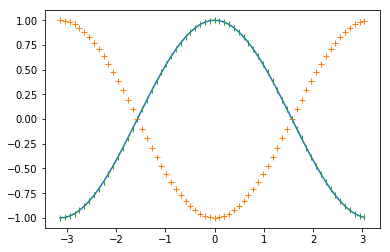

In [8]:
D = np.fft.ifft(-1j*k*np.fft.fft(np.eye(N), axis=1), axis=1)
f = np.sin(x)
plt.plot(x, np.cos(x))
plt.plot(x, np.fft.ifft(-1j*k*np.fft.fft(f)), '+')   # This minus sign seems wrong.  Why?
plt.plot(x, D.dot(f), '|')
D2 = -D.dot(D.T.conj())

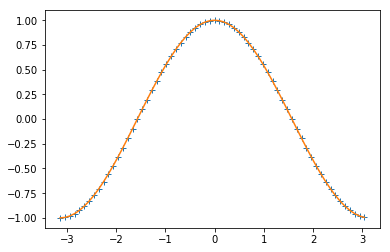

In [9]:
f = np.sin(x)
plt.plot(x, D.dot(f), '+')
plt.plot(x, np.cos(x))

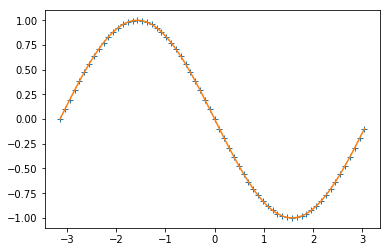

In [10]:
f = np.sin(x)
plt.plot(x, D2.dot(f), '+')
plt.plot(x, -np.sin(x))

### 2D Case

In [11]:
def fft2(y):
    return np.fft.fftn(y, axes=(0,1))           
def ifft2(y):
    return np.fft.ifftn(y, axes=(0,1))
def f(x,y):
    return np.sin(x + y)

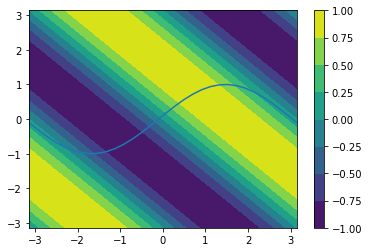

In [12]:
N = 32
L = 2*np.pi
dx = L/N
dy = dx
x = np.linspace(0,L,N) - L/2
y = np.linspace(0,L,N) - L/2
xx,yy = np.meshgrid(x,y)
z = np.sin(xx + yy) # sin(x^2 + y^2)
plt.contourf(x,y,z)
plt.plot(x,z[16])
plt.colorbar()
mat_shape = (N**2,)*2
Nxy = (N,N)
kxy = (2*np.pi * np.fft.fftfreq(N, dx)[:, None],2*np.pi * np.fft.fftfreq(N, dy)[None, :])
tensor_shape = (N,N,N,N)

In [13]:
nabla = np.eye(mat_shape[0]).reshape(tensor_shape)
K = np.eye(mat_shape[0]).reshape(tensor_shape)
D1 = ifft2(1j*sum(_k  for _k in kxy)[:, :,  None, None]*fft2(nabla)).reshape((np.prod(Nxy),)*2).reshape(mat_shape)
D2 = ifft2(sum(-_k**2 for _k in kxy)[:, :,  None, None]*fft2(K)).reshape((np.prod(Nxy),)*2).reshape(mat_shape)

c:\users\chunde\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  This is separate from the ipykernel package so we can avoid doing imports until
c:\users\chunde\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  after removing the cwd from sys.path.


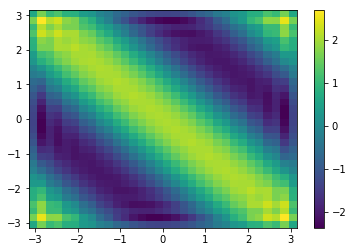

In [14]:
z1=D1.dot(z.ravel()).reshape(N,N)
imcontourf(x,y,z1.real)
#plt.plot(x,z1[32])
plt.colorbar()

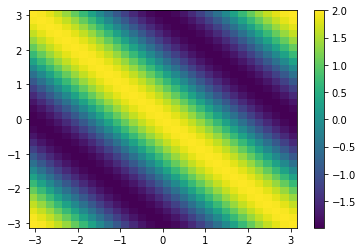

In [15]:
#z2 = (2*xx + 2 * yy) * np.cos(xx**2+yy**2)
z2 = 2*np.cos(xx+yy)#np.cos(xx)*np.cos(yy)-np.sin(xx)*np.sin(yy)# (2*yy+2*xx)* np.cos(xx**2+yy**2)
imcontourf(x,y,z2)
#plt.plot(x,z2[32])
plt.colorbar()

In [16]:
np.allclose(z1,z1.T.conj()),np.allclose(z2,z2.T.conj())

(False, True)

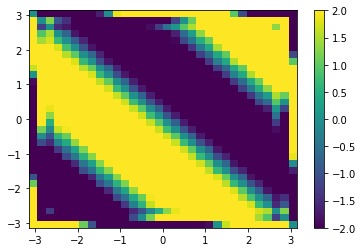

In [17]:
z3=D1.dot(z1.ravel()).reshape(N,N)#D2.dot(z.ravel()).reshape(N,N)
imcontourf(x,y,z3.real, vmin=-2.0, vmax=2.0)
#plt.plot(x,z1[32])
plt.colorbar()

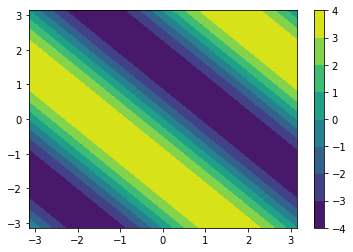

In [18]:
#z2 = (2*xx + 2 * yy) * np.cos(xx**2+yy**2)
z4 =-4*np.sin(xx+yy)#-2*(np.sin(xx)*np.cos(yy)+np.cos(xx)*np.sin(yy))#4*np.cos(xx**2 + yy**2) -4*(xx+yy)**2*np.sin(xx**2+yy**2)
plt.contourf(x,y,z4)
#plt.plot(x,z2[32])
plt.colorbar()

### Better Solutions

$$
  \int\left(\alpha(x) \frac{\hbar^2}{2m}\tau(x) + D(n)\right)\d{x}
$$
$$
  E = \sum_x\alpha(x)|\nabla\psi(x)|^2\\
$$
$$
  E = \sum_x\alpha(x) \psi'(x){\psi^\dagger}'(x)
$$

$$
  \psi^\dagger\cdot D^\dagger \cdot A \cdot  D\cdot\psi\\
  K = D^\dagger \cdot A \cdot  D
$$



$$
  (AB)' = A'B + AB'\\
  D\cdot(AB) = [D\cdot A]B + A[D\cdot B]
$$

Populating the interactive namespace from numpy and matplotlib


c:\users\chunde\appdata\local\programs\python\python37\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['ifft2', 'f', 'fft2']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


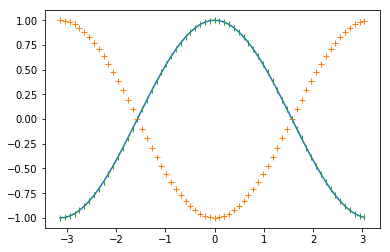

In [19]:
%pylab inline
import numpy as np
N = 64
L = 2*np.pi
dx = L / N
x = np.arange(N) * dx - L / 2
k = 2*np.pi * np.fft.fftfreq(N, dx)
D = (-np.diag(np.ones(N)) + np.diag(np.ones(N-1), k=1))/dx
D[-1, 0] = 1./dx
D2 = -D.dot(D.T.conj())


D = np.fft.ifft(-1j*k*np.fft.fft(np.eye(N), axis=1), axis=1)
f = np.sin(x)
plt.plot(x, np.cos(x))
plt.plot(x, np.fft.ifft(-1j*k*np.fft.fft(f)), '+')   # This minus sign seems wrong.  Why?
plt.plot(x, D.dot(f), '|')
D2 = -D.dot(D.T.conj())

$$
  (A\psi')' = A' \psi' + A\psi''\\
  (A\psi)'' = (A'\psi + A\psi')' = (A''\psi + A\psi'' + 2 A'\psi')\\
 A'\psi' = \frac{(A\psi)'' - A''\psi - A\psi''}{2}\\
  (A\psi')' = \frac{(A\psi)'' - A''\psi + A\psi''}{2}
$$

I need to reformula the above argument a bit carefully

\begin{align}
(\alpha \psi')'&=\alpha'\psi' + \alpha \psi'' \\
(\alpha \psi)''&=(\alpha'\psi+\alpha\psi')'\\
&=(\alpha''\psi+\alpha\psi''+2\alpha'\psi')\\
\alpha'\psi'&=\frac{(\alpha\psi)'' -\alpha''\psi-\alpha\psi''}{2}\\
so\\
(\alpha\psi')'&=\frac{(\alpha\psi)''-\alpha''\psi+\alpha\psi''}{2}
\end{align}

The interesting part of the relation is the $(\alpha\psi)''$, which can be put in martrix form as: $D2.dot(diag(\alpha))$, change a vector of $\alpha$ to a diagnized matrix will automatically make the operator works properly, that's really amazing!

In [20]:
# Numerical checks of the formula
alpha = np.exp(np.sin(x))
A = np.diag(alpha)
K_ = np.diag(D.dot(alpha)).dot(D) + A.dot(D2)
print(np.allclose(K_, K_.conj().T))
#K=A.D2-D2.A
K = (A.dot(D2) - np.diag(D2.dot(alpha)) + D2.dot(A))/2
assert np.allclose(D2, D2.conj().T)
assert np.allclose(K, K.conj().T)

False


## Error Analysis

In [21]:
%pylab inline --no-import-all
import bcs;reload(bcs)
import homogeneous;reload(homogeneous)

delta = 1.0
mu_eff = 1.0
m = 1.0
v_0, n, mu, e_0 = homogeneous.get_BCS_v_n_e(delta=delta, mu_eff=mu_eff)

N_twist = 2

def get_err(N, L, N_twist=1):
    b = bcs.BCS(T=0, N=N, L=L)
    R = b.get_R(mus=(mu_eff, mu_eff), delta=delta, N_twist=N_twist)
    na = np.diag(R)[:N]/b.dx
    nb = (1 - np.diag(R)[N:])/b.dx
    kappa = - np.diag(R[:N, N:])/b.dx

    k_max = np.pi*N/L
    dn_UV = 2*b.m**2*delta**2/3/np.pi/k_max**3 + 8*b.m**3*mu_eff*delta**2/5/np.pi/k_max**5
    dd_UV = v_0*b.m*delta/np.pi/k_max + 2*v_0*b.m**2*mu_eff/3/np.pi/k_max**3
    return [[na[0].real + nb[0].real, -v_0*kappa[0].real],[dn_UV, dd_UV]]

def get_errs(Ns, Ls, N_twist=1):
    Ns, Ls = np.asarray(Ns), np.asarray(Ls)
    res_NL = []
    res_UV = []
    for L in Ls:
        res_NL_ = []
        res_UV_ = []
        for N in Ns:
            n_d, d_UV = get_err(N=N, L=L, N_twist=N_twist)
            res_NL_.append(n_d)
            res_UV_.append(d_UV)
        res_NL.append(res_NL_)
        res_UV.append(res_UV_)
    return np.array([res_NL, res_UV])

Populating the interactive namespace from numpy and matplotlib


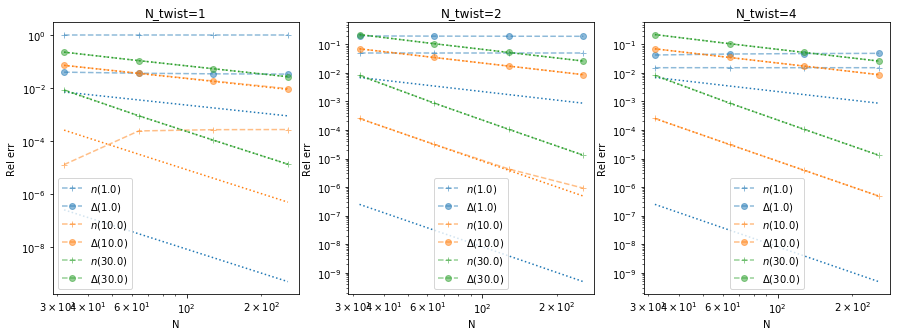

In [22]:
Ns = 2**np.arange(5, 9)
Ls = [1.0, 10.0, 30.0]
N_twists = [1, 2, 4]
plt.figure(figsize=(5*len(N_twists), 5))
for _n, N_twist in enumerate(N_twists):
    res_NL, res_UV = get_errs(Ns=Ns, Ls=Ls, N_twist=N_twist)
    n_, d_ = np.array(res_NL).T
    plt.subplot(101 + len(N_twists)*10 + _n)
    for _i, L in enumerate(Ls):
        _l, = plt.loglog(Ns, abs(n_[:, _i]-n)/n, '--+', label='$n({})$'.format(L), alpha=0.5)
        plt.loglog(Ns, abs(d_[:, _i]-delta)/delta, '--o', c=_l.get_c(),
                   label=r'$\Delta({})$'.format(L), alpha=0.5)
        plt.loglog(Ns, abs(res_UV[_i, :, 0])/n, ':', c=_l.get_c())
        plt.loglog(Ns, abs(res_UV[_i, :, 1])/delta, ':', c=_l.get_c())
    plt.ylabel('Rel err')
    plt.xlabel('N')
    plt.legend()
    plt.title("N_twist={}".format(N_twist))

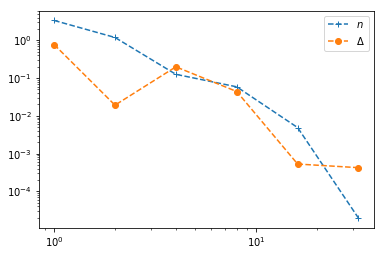

In [23]:
L = 0.46
N = 2**8
N_twists = 2**np.arange(0,6)

res = np.array([get_err(N=N, L=L, N_twist=N_twist)[0]
                for N_twist in N_twists])
plt.loglog(N_twists, abs(res[:,0] - n)/n, '--+', label='$n$')
plt.loglog(N_twists, abs(res[:,1] - delta)/delta, '--o', label=r'$\Delta$')
plt.legend()

In [24]:
Ls = np.linspace(10.0, 30.0, 20)
res = []
for L in Ls:
    b = bcs.BCS(T=0, N=2**10, L=L)
    N = b.N
    R = b.get_R(mus=(mu_eff, mu_eff), delta=delta)
    na = np.diag(R)[:N]/b.dx
    nb = (1 - np.diag(R)[N:])/b.dx
    kappa = - np.diag(R[:N, N:])/b.dx
    #na, nb, kappa
    res.append((na[0].real + nb[0].real, -v_0*kappa[0].real))
n_, d_ = np.array(res).T

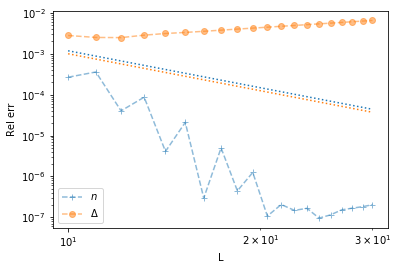

In [25]:
_l_n, = plt.loglog(Ls, abs(n_-n)/n, '--+', label='$n$', alpha=0.5)
_l_d, = plt.loglog(Ls, abs(d_-delta)/delta, '--o', label=r'$\Delta$', alpha=0.5)
plt.loglog(Ls, abs(1./Ls**3)/n, ':', c=_l_n.get_c())
plt.loglog(Ls, abs(1./Ls**3)/delta, ':', c=_l_d.get_c())

plt.ylabel('Rel err')
plt.xlabel('L')
plt.legend()

# How to extend the 2d Lattice code to 3D?


If we assume the z direction is homogenous, then the wavefuction can be expressed as:
$$
\psi(x,y,z)=\psi(x,y)\psi(z)
$$
and from the Schödinger equation:
$$
-\frac{\hbar^2}{2m}\left[\frac{\partial^2}{\partial x^2}+\frac{\partial^2}{\partial y^2}+\frac{\partial^2}{\partial z^2}\right]\psi(x,y,z) + V(x,y)\psi(x,y,z)=(E_{xy} + E_z)\psi(x,y,z)\\
-\frac{\hbar^2}{2m}\left[\frac{\partial^2}{\partial x^2}+\frac{\partial^2}{\partial y^2}+\frac{\partial^2}{\partial z^2}\right]\psi(x,y)\psi(z) + V(x,y)\psi(x,y)\psi(z)=(E_{xy} + E_z)\psi(x,y)\psi(z)
$$


The overall equation can be decomposed into two seperate equations:
$$
-\frac{\hbar^2}{2m}\left[\frac{\partial^2}{\partial x^2}+\frac{\partial^2}{\partial y^2}\right]\psi(x,y) + V(x,y)\psi(x,y)=E_{xy}\psi(x,y)\\
-\frac{\hbar^2}{2m}\left[\frac{\partial^2}{\partial z^2}\right]\psi(z)=E_z\psi(z)
$$
So if we have lattice for x-y direction, to extend to 3d case, we may only add a const term to the kenitic terms.